In [52]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import norm
import importlib

# Set plot style
sns.set_style('darkgrid')

from src.stock_path_simulator import StockPathSimulator

## Perpetual American Put Options

The simplest theoretical case of an American Put Option is a perpetual one where the expiration date is set to infinity. One can assume that, because time is set to infinite, the strategy of whether to exercise or not depends only on the price of the stock, not on time. The price of the perpetual American put is defined as:

$$
v(x) = \max_{\tau\in T} \tilde{E}[e^{-r\tau}(K-S(\tau))]
$$

where $K$ is the strike price, $S(\tau)$ is the price of the underlying asset at time $\tau$, $T$ is the set of all stopping times, and the exponential term tracks the growth of money under fixed interest rate $r$. 

Assume that the stock asset is priced as a geometric Brownian motion:

$$
S(t) = S(0) \exp\left\{\sigma \tilde{W}(t) + \left(r-\frac{1}{2}\sigma^2\right) t\right\}
$$

with a Wiener process $\tilde{W}(t)$. If the owner uses a strategy to exercise the option as soon as it falls below a value $L$, exercising at $\tau_L = \min(t\geq 0;S(t)=L)$, then the value function is:

$$
v_L(x)=\begin{cases}
K - x, & 0 \le x \le L,\\[6pt]
(K-L)\left(\dfrac{x}{L}\right)^{-\frac{2r}{\sigma^{2}}}, & x \ge L .
\end{cases}
$$

where the first case corresponds to exercising at $t=0$ (the stock value is below $L$), and the second case is the expected value when waiting for the stock price to drop below $L$. Following Steve Shreve 8.3, this function $v_L(x)$ has a well-defined optimum at:

$$L_* = \frac{2r}{2r+\sigma^2}K$$

# Monte Carlo Analysis of Perpetual American Put Options

Let's perform a Monte Carlo simulation to analyze the perpetual American put option and find the optimal exercise boundary.

In [53]:
# Model parameters
S0 = 140       # Initial stock price
K = 140        # Strike price
sigma = 0.3    # Volatility
r = 0.035      # Risk-free rate
T = 1000         # Time horizon (years)
mu = 0         # Drift (risk-neutral)
# Simulation parameters
simulation_amounts = 1000
n_steps = 10000

# Create StockPathSimulator instance with explicit parameters
sps = StockPathSimulator(
    S0=S0,
    sigma=sigma,
    T=T,
    r=r,
    mu=mu,
    n_sims=simulation_amounts,
    n_steps=n_steps
)

# Alternative: you can also use keyword arguments selectively
# sps = StockPathSimulator(S0=S0, sigma=sigma, r=r, n_sims=simulation_amounts)

print(f"Created simulator with S0={sps.S0}, sigma={sps.sigma}, r={sps.r}")

Created simulator with S0=140, sigma=0.3, r=0.035


In [54]:
def return_for_perpetual_american_put_simulation(L):
    """
    Simulate stock paths and calculate the return for a perpetual American put option.
    For perpetual options, we need to generate fresh paths for each L to avoid bias.
    """
    # Generate fresh paths for each L value
    paths = sps.stock_paths
    
    payoffs = []
    exercise_times = []

        # For each path, use the strategy with L to determine its payoff
    for i in range(sps.n_sims):
        path = paths[i]
        exercised = False
        
        # Check if we should exercise immediately (at t=0)
        if path[0] <= L:
            # Exercise immediately at t=0, no discounting needed
            payoff = sps.put_option_payoff(path[0], K, 0)  # t=0 for immediate exercise
            payoffs.append(payoff)
            exercise_times.append(0)
            exercised = True
        else:
            # Look for first hitting time when stock goes at or below boundary L
            for j in range(1, len(path)):
                if path[j] <= L:
                    # Exercise option at first time stock hits or goes below boundary
                    exercise_time = T * (j / n_steps)  # Actual time when exercised
                    payoff = sps.put_option_payoff(path[j], K, exercise_time)
                    payoffs.append(payoff)
                    exercise_times.append(j)
                    exercised = True
                    break
        
        if not exercised:
            # For perpetual options, if boundary never hit, option has no value
            # (This shouldn't happen often with reasonable L values)
            payoffs.append(0)
            exercise_times.append(n_steps)

    average_payoff = np.mean(payoffs)
    std_payoff = np.std(payoffs)/np.sqrt(len(payoffs))
    
    # Calculate proportion that exercised
    exercised_count = sum(1 for t in exercise_times if t < n_steps)
    
    # Only print summary, not individual paths (too verbose)
    print(f"L={L:.1f}: Avg Payoff={average_payoff:.4f}, Std={std_payoff:.4f}, Exercises: {exercised_count}/{len(exercise_times)} ({100*exercised_count/len(exercise_times):.1f}%)")

    return average_payoff, std_payoff, payoffs, exercise_times

Model parameters:
S0 = 140, K = 140, sigma = 0.3, r = 0.035
Alpha parameter: 0.4375
Theoretical optimal exercise boundary: L* = 61.25

Running simulations...
L=42.0: Avg Payoff=37.7506, Std=1.0004, Exercises: 978/1000 (97.8%)
L=47.0: Avg Payoff=38.9537, Std=0.9707, Exercises: 981/1000 (98.1%)
L=52.0: Avg Payoff=39.9548, Std=0.9424, Exercises: 984/1000 (98.4%)
L=57.0: Avg Payoff=40.9438, Std=0.9072, Exercises: 985/1000 (98.5%)
L=62.0: Avg Payoff=40.9682, Std=0.8650, Exercises: 985/1000 (98.5%)
L=67.0: Avg Payoff=40.7376, Std=0.8309, Exercises: 987/1000 (98.7%)
L=72.0: Avg Payoff=40.3565, Std=0.7787, Exercises: 988/1000 (98.8%)
L=77.0: Avg Payoff=39.5318, Std=0.7288, Exercises: 988/1000 (98.8%)
L=82.0: Avg Payoff=38.5984, Std=0.6666, Exercises: 989/1000 (98.9%)
L=87.0: Avg Payoff=37.3118, Std=0.6101, Exercises: 991/1000 (99.1%)
L=92.0: Avg Payoff=36.0867, Std=0.5545, Exercises: 992/1000 (99.2%)
L=97.0: Avg Payoff=34.3256, Std=0.5017, Exercises: 993/1000 (99.3%)

Results Summary:
       L

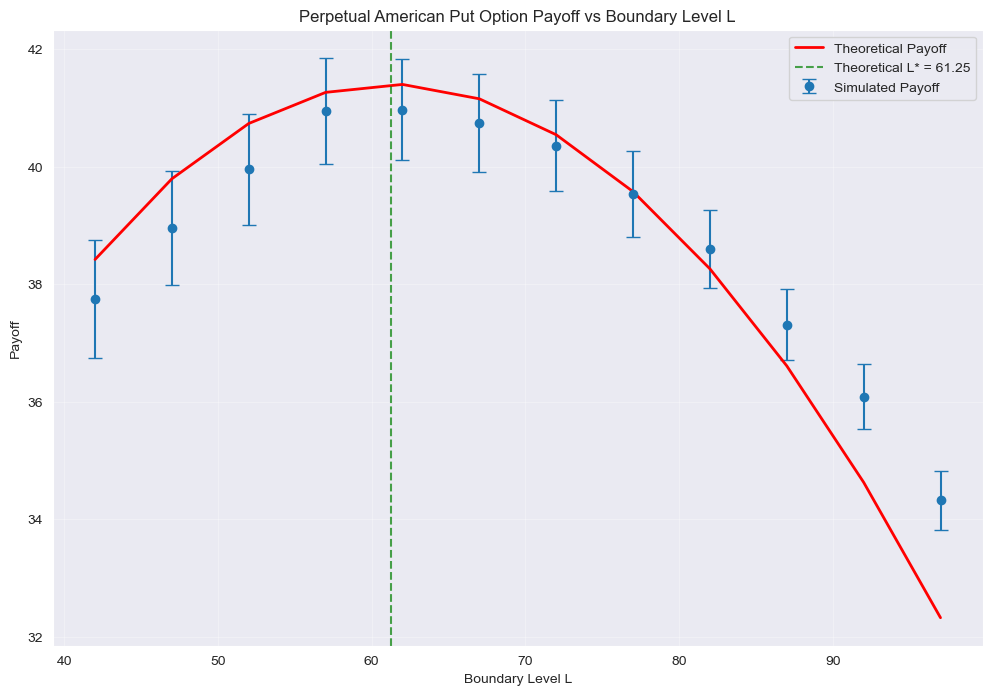


Optimal boundary analysis:
Simulated optimal L: 62.0
Theoretical optimal L: 61.25
Maximum simulated payoff: 40.9682
Theoretical payoff at optimal L: 41.4010



In [55]:
# First, let's calculate the theoretical optimal boundary
alpha = (2 * r) / (2 * r + sigma**2)
theoretical_optimal_L = K * alpha

print(f"Model parameters:")
print(f"S0 = {S0}, K = {K}, sigma = {sigma}, r = {r}")
print(f"Alpha parameter: {alpha:.4f}")
print(f"Theoretical optimal exercise boundary: L* = {theoretical_optimal_L:.2f}")
print()

# Test L values around the theoretical optimum, but also include the range used before
L_values = np.arange(0.3*K, 0.7*K, 5)  # More focused range around reasonable values
results = []

print("Running simulations...")
for L in L_values:
    avg_payoff, std_payoff, payoffs, exercise_times = return_for_perpetual_american_put_simulation(L)
    results.append((L, avg_payoff, std_payoff))

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['L', 'Average Payoff', 'Std Dev'])
print("\nResults Summary:")
print(results_df)

# Plot the results
plt.figure(figsize=(12, 8))
plt.errorbar(results_df['L'], results_df['Average Payoff'], yerr=results_df['Std Dev'], 
             fmt='o', label='Simulated Payoff', capsize=5, markersize=6)

# Theoretical value calculation - this is the value when starting at S0=140
theoretical_values = []
for L in L_values:
    if S0 <= L:
        # If current price is below boundary, exercise immediately
        theoretical_value = K - S0
    else:
        # If current price is above boundary, use the formula
        theoretical_value = (K - L) * (S0 / L) ** (-2 * r / sigma**2)
    theoretical_values.append(theoretical_value)

plt.plot(L_values, theoretical_values, label='Theoretical Payoff', color='red', linewidth=2)

# Mark the theoretical optimal boundary
plt.axvline(x=theoretical_optimal_L, color='green', linestyle='--', 
            label=f'Theoretical L* = {theoretical_optimal_L:.2f}', alpha=0.7)

plt.xlabel('Boundary Level L')
plt.ylabel('Payoff')
plt.title('Perpetual American Put Option Payoff vs Boundary Level L')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the optimal L from simulation
optimal_idx = np.argmax(results_df['Average Payoff'])
optimal_L_sim = results_df.iloc[optimal_idx]['L']
max_payoff_sim = results_df.iloc[optimal_idx]['Average Payoff']

print(f"\nOptimal boundary analysis:")
print(f"Simulated optimal L: {optimal_L_sim:.1f}")
print(f"Theoretical optimal L: {theoretical_optimal_L:.2f}")
print(f"Maximum simulated payoff: {max_payoff_sim:.4f}")
print(f"Theoretical payoff at optimal L: {(K - theoretical_optimal_L) * (S0 / theoretical_optimal_L) ** (-2 * r / sigma**2):.4f}")
print()

There are three parameters that govern the accuracy of the perpetual American option simulation: the time horizon (T), the number of timesteps (n_steps) and the simulation amount (simulation_amounts). simulation_amounts controls the Monte Carlo variance: the standard error is given central limit theorem as $SE = s/\sqrt{n_\text{steps}}$, where $s$ is the sample standard deviation of the discounted payoff per path. On the other hand, the error from finite time (T) and finite timesteps (n_steps)  are harder to quantify a priori. The above simulation doesn't accurately reproduce due to the finite time horizon. Below, I tabulate the payoff as a function of T and n_steps to obtain the payoff and error from averaging over simulation, as well as the requried runtime.

In [43]:
import time

# Use the theoretical optimal boundary for benchmarking
benchmark_L = theoretical_optimal_L

# Define parameter ranges to test
simulation_amounts_values = [10000]
T_values = [50, 100, 500, 1000, 2000, 5000]
n_steps_values = [500, 1000, 5000, 10000, 20000, 50000]

# Store results
benchmark_results = []

print(f"Benchmarking with L = {benchmark_L:.2f} (theoretical optimal)")
print(f"Testing {len(simulation_amounts_values)} simulation amounts x {len(T_values)} T values x {len(n_steps_values)} n_steps")
print(f"Total combinations: {len(T_values) * len(simulation_amounts_values) * len(n_steps_values)}")
print("\n" + "="*100)

# Iterate through all combinations
for T_test in T_values:
    for sim_amt in simulation_amounts_values:
        for n_steps_test in n_steps_values:
            print(f"\nTesting: T={T_test}, sim_amt={sim_amt}, n_steps={n_steps_test}")
            
            # Create a new simulator with these parameters
            start_time = time.time()
            test_sps = StockPathSimulator(
                S0=S0,
                sigma=sigma,
                T=T_test,
                r=r,
                mu=mu,
                n_sims=sim_amt,
                n_steps=n_steps_test
            )
            
            # Run simulation with benchmark L
            paths = test_sps.stock_paths
            payoffs = []
            exercise_times = []
            
            for i in range(test_sps.n_sims):
                path = paths[i]
                exercised = False
                
                # Check if we should exercise immediately (at t=0)
                if path[0] <= benchmark_L:
                    payoff = test_sps.put_option_payoff(path[0], K, 0)
                    payoffs.append(payoff)
                    exercise_times.append(0)
                    exercised = True
                else:
                    # Look for first hitting time
                    for j in range(1, len(path)):
                        if path[j] <= benchmark_L:
                            exercise_time = T_test * (j / n_steps_test)
                            payoff = test_sps.put_option_payoff(path[j], K, exercise_time)
                            payoffs.append(payoff)
                            exercise_times.append(j)
                            exercised = True
                            break
                
                if not exercised:
                    payoffs.append(0)
                    exercise_times.append(n_steps_test)
            
            avg_payoff = np.mean(payoffs)
            std_payoff = np.std(payoffs) / np.sqrt(len(payoffs))
            exercised_count = sum(1 for t in exercise_times if t < n_steps_test)
            exercise_rate = exercised_count / len(exercise_times)
            
            elapsed_time = time.time() - start_time
            
            # Store results
            benchmark_results.append({
                'T': T_test,
                'simulation_amounts': sim_amt,
                'n_steps': n_steps_test,
                'avg_payoff': avg_payoff,
                'std_payoff': std_payoff,
                'exercise_rate': exercise_rate,
                'time_seconds': elapsed_time
            })
            
            print(f"  Payoff: {avg_payoff:.4f} ± {std_payoff:.4f}")
            print(f"  Exercise rate: {exercise_rate*100:.1f}%")
            print(f"  Time: {elapsed_time:.2f}s")

# Convert to DataFrame for analysis
benchmark_df = pd.DataFrame(benchmark_results)

print("\n" + "="*100)
print(f"\nBenchmarking complete! Total runs: {len(benchmark_df)}")

Benchmarking with L = 61.25 (theoretical optimal)
Testing 1 simulation amounts x 6 T values x 6 n_steps
Total combinations: 36


Testing: T=50, sim_amt=10000, n_steps=500
  Payoff: 40.2057 ± 0.2856
  Exercise rate: 73.8%
  Time: 0.28s

Testing: T=50, sim_amt=10000, n_steps=1000
  Payoff: 40.6465 ± 0.2828
  Exercise rate: 74.6%
  Time: 0.48s

Testing: T=50, sim_amt=10000, n_steps=5000
  Payoff: 40.8918 ± 0.2781
  Exercise rate: 75.3%
  Time: 2.32s

Testing: T=50, sim_amt=10000, n_steps=10000
  Payoff: 40.9614 ± 0.2790
  Exercise rate: 75.1%
  Time: 4.64s

Testing: T=50, sim_amt=10000, n_steps=20000
  Payoff: 40.4090 ± 0.2759
  Exercise rate: 75.6%
  Time: 9.60s

Testing: T=50, sim_amt=10000, n_steps=50000
  Payoff: 41.3310 ± 0.2753
  Exercise rate: 76.3%
  Time: 29.88s

Testing: T=100, sim_amt=10000, n_steps=500
  Payoff: 41.2719 ± 0.2803
  Exercise rate: 83.3%
  Time: 0.30s

Testing: T=100, sim_amt=10000, n_steps=1000
  Payoff: 40.7906 ± 0.2749
  Exercise rate: 83.5%
  Time: 0.40s

Tes

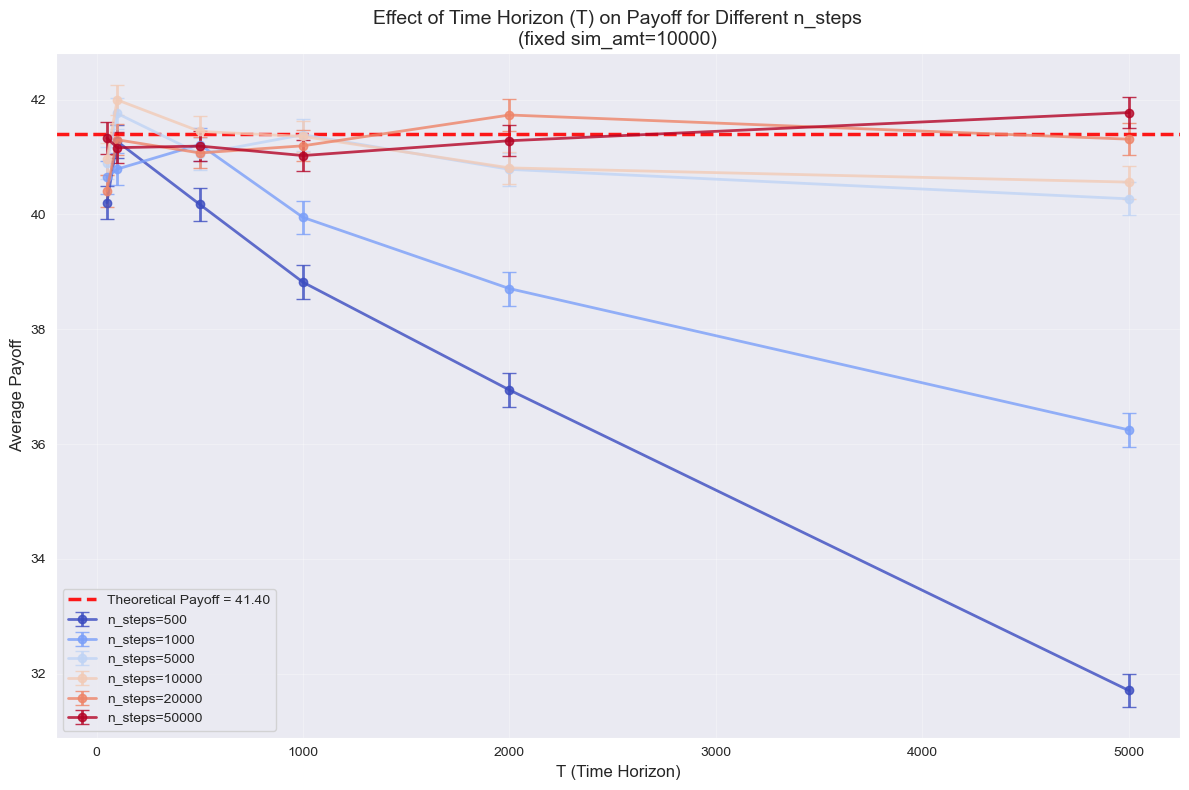

Theoretical payoff at optimal L: 41.4010

Observations:
- T needs to be sufficiently large to allow boundary hitting
- Only a moderate amount of T is needed for convergence, beyond which error from n_sims obscures further gains
- However, a too small n_steps compared to T can lead to significant underestimation of payoff


In [44]:
# Plot: Effect of T on payoff while changing n_steps
# This shows how both time horizon and discretization affect convergence to theoretical value
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate theoretical payoff at optimal L
theoretical_payoff = (K - theoretical_optimal_L) * (S0 / theoretical_optimal_L) ** (-2 * r / sigma**2)
# Fix simulation_amounts and vary n_steps for different T values
fixed_sim_amt = 10000

# Create a colormap that varies with n_steps
# Using 'coolwarm' (blue to red) - no yellow, clear progression
cmap = plt.cm.coolwarm  # Other good options: 'RdYlBu_r', 'Spectral_r', 'plasma'
colors = [cmap(i / (len(n_steps_values) - 1)) for i in range(len(n_steps_values))]

for idx, n_steps_val in enumerate(n_steps_values):
    subset = benchmark_df[(benchmark_df['simulation_amounts'] == fixed_sim_amt) & 
                          (benchmark_df['n_steps'] == n_steps_val)]
    if len(subset) > 0:  # Only plot if data exists
        ax.errorbar(subset['T'], subset['avg_payoff'], yerr=subset['std_payoff'], 
                    marker='o', label=f'n_steps={n_steps_val}', 
                    color=colors[idx], capsize=5, alpha=0.8, linewidth=2, markersize=6)

# Add theoretical payoff line for reference
ax.axhline(y=theoretical_payoff, color='red', linestyle='--', linewidth=2.5,
           label=f'Theoretical Payoff = {theoretical_payoff:.2f}', alpha=0.9)

ax.set_xlabel('T (Time Horizon)', fontsize=12)
ax.set_ylabel('Average Payoff', fontsize=12)
ax.set_title(f'Effect of Time Horizon (T) on Payoff for Different n_steps\n(fixed sim_amt={fixed_sim_amt})', 
             fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Theoretical payoff at optimal L: {theoretical_payoff:.4f}")
print(f"\nObservations:")
print("- T needs to be sufficiently large to allow boundary hitting")
print("- Only a moderate amount of T is needed for convergence, beyond which error from n_sims obscures further gains")
print("- However, a too small n_steps compared to T can lead to significant underestimation of payoff")

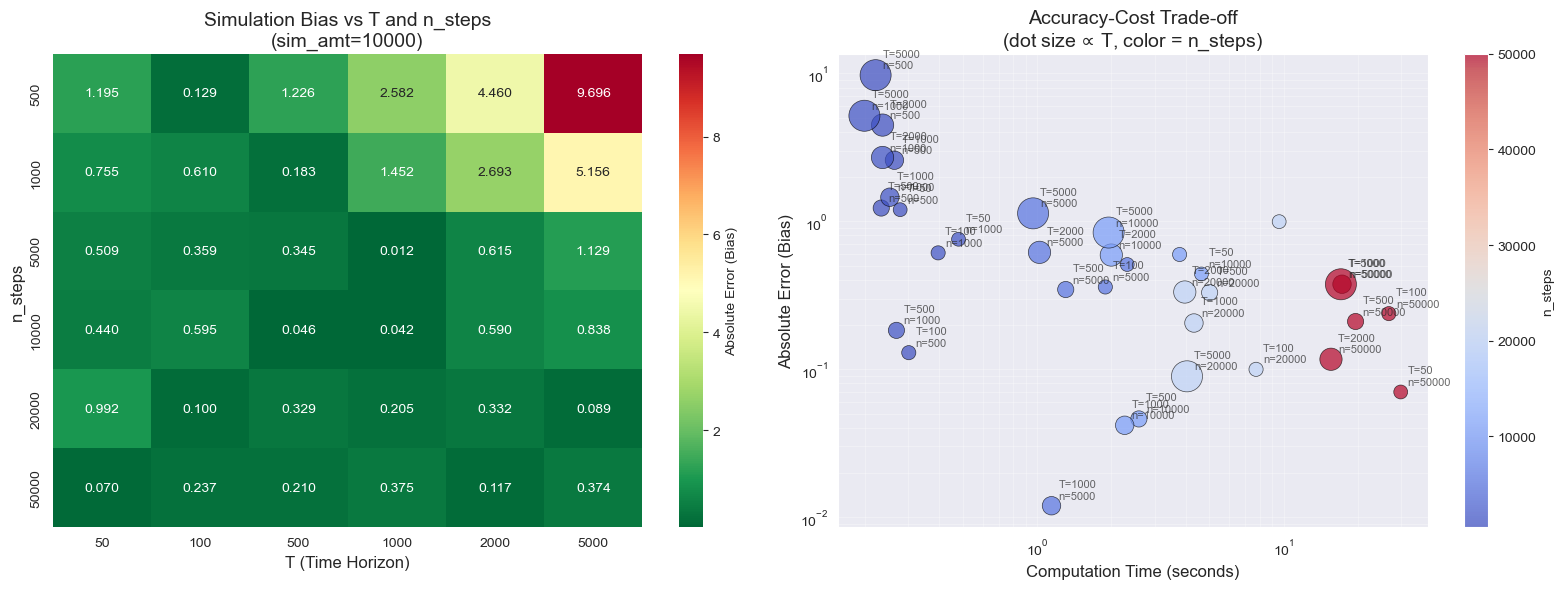


Accuracy-Cost Analysis:
Theoretical payoff: 41.4010

Best accuracy (lowest abs_error):
  T=1000, n_steps=5000
  Error: 0.0119, Time: 1.14s

Best efficiency (lowest abs_error × time):
  T=1000, n_steps=5000
  Error: 0.0119, Time: 1.14s


In [45]:
# Plot: Error and time analysis - showing the accuracy-cost trade-off
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

fixed_sim_amt = 10000
theoretical_payoff = (K - theoretical_optimal_L) * (S0 / theoretical_optimal_L) ** (-2 * r / sigma**2)

# Calculate absolute error (bias) from theoretical value
benchmark_df['abs_error'] = np.abs(benchmark_df['avg_payoff'] - theoretical_payoff)

# 1. Heatmap of absolute error (bias)
ax = axes[0]
pivot_error = benchmark_df[benchmark_df['simulation_amounts'] == fixed_sim_amt].pivot(
    index='n_steps', columns='T', values='abs_error'
)
sns.heatmap(pivot_error, annot=True, fmt='.3f', cmap='RdYlGn_r', ax=ax, 
            cbar_kws={'label': 'Absolute Error (Bias)'})
ax.set_title(f'Simulation Bias vs T and n_steps\n(sim_amt={fixed_sim_amt})', fontsize=14)
ax.set_xlabel('T (Time Horizon)', fontsize=12)
ax.set_ylabel('n_steps', fontsize=12)

# 2. Efficiency scatter plot: error vs time, sized by T, colored by n_steps
ax = axes[1]
subset = benchmark_df[benchmark_df['simulation_amounts'] == fixed_sim_amt]

# Create size array based on T values (larger T = larger dots)
T_min, T_max = subset['T'].min(), subset['T'].max()
sizes = 100 + 400 * (subset['T'] - T_min) / (T_max - T_min)

scatter = ax.scatter(subset['time_seconds'], subset['abs_error'], 
                     c=subset['n_steps'], s=sizes, alpha=0.7, cmap='coolwarm',
                     edgecolors='black', linewidth=0.5)

# Add colorbar for n_steps
cbar = plt.colorbar(scatter, ax=ax, label='n_steps')

# Annotate a few key points
for idx, row in subset.iterrows():
    if row['abs_error'] < 0.5 or row['time_seconds'] < 2:  # Annotate interesting points
        ax.annotate(f"T={int(row['T'])}\nn={int(row['n_steps'])}", 
                   xy=(row['time_seconds'], row['abs_error']),
                   xytext=(5, 5), textcoords='offset points', 
                   fontsize=8, alpha=0.7)

ax.set_xlabel('Computation Time (seconds)', fontsize=12)
ax.set_ylabel('Absolute Error (Bias)', fontsize=12)
ax.set_title(f'Accuracy-Cost Trade-off\n(dot size $∝$ T, color = n_steps)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nAccuracy-Cost Analysis:")
print(f"Theoretical payoff: {theoretical_payoff:.4f}")
print(f"\nBest accuracy (lowest abs_error):")
best_acc = benchmark_df.loc[benchmark_df['abs_error'].idxmin()]
print(f"  T={int(best_acc['T'])}, n_steps={int(best_acc['n_steps'])}")
print(f"  Error: {best_acc['abs_error']:.4f}, Time: {best_acc['time_seconds']:.2f}s")
print(f"\nBest efficiency (lowest abs_error × time):")
benchmark_df['error_time_product'] = benchmark_df['abs_error'] * benchmark_df['time_seconds']
best_eff = benchmark_df.loc[benchmark_df['error_time_product'].idxmin()]
print(f"  T={int(best_eff['T'])}, n_steps={int(best_eff['n_steps'])}")
print(f"  Error: {best_eff['abs_error']:.4f}, Time: {best_eff['time_seconds']:.2f}s")

This verification suggests that one needs a moderate amount of time horizon $T\sim 500$ and $n_\text{steps} \sim 500$ before the error is dominated by finite Monte-Carlo sampling, which would take less than a second on my laptop to run.

# Perpetual American Call Option

The price of perpetual American option can be derived similarly as (assuming $L > K$) (
See https://personal.ntu.edu.sg/nprivault/MA5182/american-options.pdf for a pedagogical derivation)

$$
v_L(x)=\begin{cases}
x - K, & x \ge L \ge K,\\[6pt]
(L-K)\left(\dfrac{x}{L}\right), & 0 < x \le L .
\end{cases}
$$

Crucially, unlike the case of put option, there is no finite optimal exercise boundary: the optimal strategy is to exercise it at infinite time. 

In [56]:
def return_for_perpetual_american_call_simulation(L):
    """
    Simulate stock paths and calculate the return for a perpetual American call option.
    For perpetual options, we need to generate fresh paths for each L to avoid bias.
    """
    # Generate fresh paths for each L value
    paths = sps.stock_paths
    
    payoffs = []
    exercise_times = []

        # For each path, use the strategy with L to determine its payoff
    for i in range(sps.n_sims):
        path = paths[i]
        exercised = False
        
        # Check if we should exercise immediately (at t=0)
        if path[0] >= L:
            # Exercise immediately at t=0, no discounting needed
            payoff = sps.call_option_payoff(path[0], K, 0)  # t=0 for immediate exercise
            payoffs.append(payoff)
            exercise_times.append(0)
            exercised = True
        else:
            # Look for first hitting time when stock goes at or above boundary L
            for j in range(1, len(path)):
                if path[j] >= L:
                    # Exercise option at first time stock hits or goes below boundary
                    exercise_time = T * (j / n_steps)  # Actual time when exercised
                    payoff = sps.call_option_payoff(path[j], K, exercise_time)
                    payoffs.append(payoff)
                    exercise_times.append(j)
                    exercised = True
                    break
        
        if not exercised:
            # For perpetual options, if boundary never hit, option has no value
            # (This shouldn't happen often with reasonable L values)
            payoffs.append(0)
            exercise_times.append(n_steps)

    average_payoff = np.mean(payoffs)
    std_payoff = np.std(payoffs)/np.sqrt(len(payoffs))
    
    # Calculate proportion that exercised
    exercised_count = sum(1 for t in exercise_times if t < n_steps)
    
    # Only print summary, not individual paths (too verbose)
    print(f"L={L:.1f}: Avg Payoff={average_payoff:.4f}, Std={std_payoff:.4f}, Exercises: {exercised_count}/{len(exercise_times)} ({100*exercised_count/len(exercise_times):.1f}%)")

    return average_payoff, std_payoff, payoffs, exercise_times

Model parameters for call option:
S0 = 140, K = 140, sigma = 0.3, r = 0.035

Running call option simulations...
Note: For non-dividend paying stocks, it's typically never optimal to exercise early

L=145.0: Avg Payoff=12.6450, Std=0.2510, Exercises: 962/1000 (96.2%)
L=155.0: Avg Payoff=19.7278, Std=0.3023, Exercises: 950/1000 (95.0%)
L=165.0: Avg Payoff=27.2665, Std=0.4061, Exercises: 940/1000 (94.0%)
L=175.0: Avg Payoff=33.4038, Std=0.5250, Exercises: 926/1000 (92.6%)
L=185.0: Avg Payoff=39.8958, Std=0.6768, Exercises: 916/1000 (91.6%)
L=195.0: Avg Payoff=44.7989, Std=0.8115, Exercises: 910/1000 (91.0%)
L=205.0: Avg Payoff=49.0469, Std=0.9352, Exercises: 899/1000 (89.9%)
L=215.0: Avg Payoff=53.0826, Std=1.0553, Exercises: 895/1000 (89.5%)
L=225.0: Avg Payoff=56.9195, Std=1.1812, Exercises: 888/1000 (88.8%)
L=235.0: Avg Payoff=60.5706, Std=1.3044, Exercises: 879/1000 (87.9%)
L=245.0: Avg Payoff=63.6582, Std=1.4299, Exercises: 871/1000 (87.1%)
L=255.0: Avg Payoff=67.3721, Std=1.5432, Ex

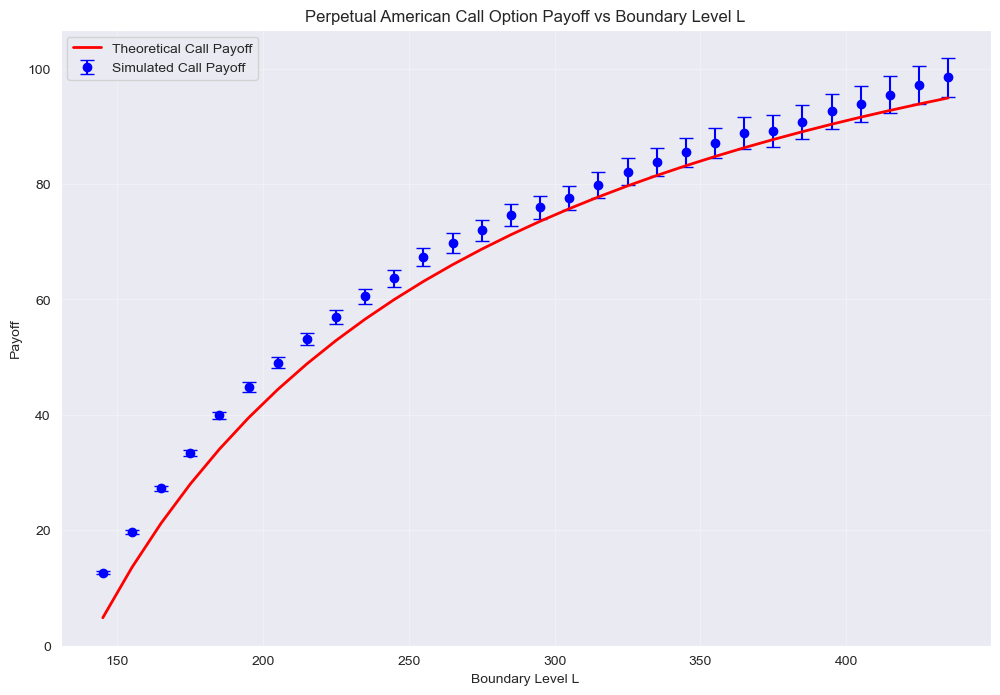


Call Option Analysis:
Simulated 'optimal' L: 435.0
Maximum simulated payoff: 98.5382
European call option value (for comparison): 0.0000

Theory note: For non-dividend paying stocks, perpetual American calls
should never be exercised early, making the optimal boundary L = ∞
The monotonically increasing payoff as L increases confirms this theoretical result.


In [58]:
# For perpetual American call options, there is no optimal finite boundary
# because it's never optimal to exercise early for a non-dividend paying stock
# However, let's analyze different boundary levels for educational purposes

# Note: For call options, L should be > K for the theoretical formula to apply
# The optimal strategy for perpetual American calls on non-dividend stocks 
# is typically to never exercise early (L = infinity)

print(f"Model parameters for call option:")
print(f"S0 = {S0}, K = {K}, sigma = {sigma}, r = {r}")
print()

# Test L values above the strike price K
L_values_call = np.arange(K + 5, K + 300, 10)  # L values above K
results_call = []

print("Running call option simulations...")
print("Note: For non-dividend paying stocks, it's typically never optimal to exercise early")
print()

for L in L_values_call:
    avg_payoff, std_payoff, payoffs, exercise_times = return_for_perpetual_american_call_simulation(L)
    results_call.append((L, avg_payoff, std_payoff))

# Convert results to DataFrame for easier plotting
results_call_df = pd.DataFrame(results_call, columns=['L', 'Average Payoff', 'Std Dev'])
print("\nCall Option Results Summary:")
print(results_call_df)

# Plot the results
plt.figure(figsize=(12, 8))
plt.errorbar(results_call_df['L'], results_call_df['Average Payoff'], yerr=results_call_df['Std Dev'], 
             fmt='o', label='Simulated Call Payoff', capsize=5, markersize=6, color='blue')

# Theoretical value calculation for call options
# For perpetual American calls: v_L(x) = (L-K)(x/L) when x <= L, and x-K when x >= L
theoretical_values_call = []
for L in L_values_call:
    if S0 >= L:
        # If current price is above boundary, exercise immediately
        theoretical_value = S0 - K
    else:
        # If current price is below boundary, use the formula: (L-K)(x/L)
        theoretical_value = (L - K) * (S0 / L)
    theoretical_values_call.append(theoretical_value)

plt.plot(L_values_call, theoretical_values_call, label='Theoretical Call Payoff', color='red', linewidth=2)

plt.xlabel('Boundary Level L')
plt.ylabel('Payoff')
plt.title('Perpetual American Call Option Payoff vs Boundary Level L')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the "optimal" L from simulation (though theory says it should be infinity)
optimal_idx_call = np.argmax(results_call_df['Average Payoff'])
optimal_L_sim_call = results_call_df.iloc[optimal_idx_call]['L']
max_payoff_sim_call = results_call_df.iloc[optimal_idx_call]['Average Payoff']

print(f"\nCall Option Analysis:")
print(f"Simulated 'optimal' L: {optimal_L_sim_call:.1f}")
print(f"Maximum simulated payoff: {max_payoff_sim_call:.4f}")
print(f"European call option value (for comparison): {max(S0 - K, 0):.4f}")
print()
print("Theory note: For non-dividend paying stocks, perpetual American calls")
print("should never be exercised early, making the optimal boundary L = ∞")
print("The monotonically increasing payoff as L increases confirms this theoretical result.")

## Benchmarking Call Option Simulation Parameters

Similar to the put option analysis, let's examine how simulation parameters (T, n_steps, simulation_amounts) affect the accuracy of our Monte Carlo estimation for call options. We estimate the payoff at a value that would still see some exercise, to benchmark the accuracy of the simulation, even if it would not be optimal to exercise at this point (and the optimal strategy is to never exercise)

In [71]:
import time

benchmark_L_call = 2 * K  

# Define parameter ranges to test
simulation_amounts_values_call = [10000]
T_values_call = [50, 100, 500, 1000, 2000, 5000]
n_steps_values_call = [500, 1000, 5000, 10000, 20000, 50000]

# Store results
benchmark_results_call = []

print(f"Benchmarking Call Option with L = {benchmark_L_call:.2f}")
print(f"Testing {len(simulation_amounts_values_call)} simulation amounts x {len(T_values_call)} T values x {len(n_steps_values_call)} n_steps")
print(f"Total combinations: {len(T_values_call) * len(simulation_amounts_values_call) * len(n_steps_values_call)}")
print("\n" + "="*100)

# Iterate through all combinations
for T_test in T_values_call:
    for sim_amt in simulation_amounts_values_call:
        for n_steps_test in n_steps_values_call:
            print(f"\nTesting: T={T_test}, sim_amt={sim_amt}, n_steps={n_steps_test}")
            
            # Create a new simulator with these parameters
            start_time = time.time()
            test_sps_call = StockPathSimulator(
                S0=S0,
                sigma=sigma,
                T=T_test,
                r=r,
                mu=mu,
                n_sims=sim_amt,
                n_steps=n_steps_test
            )
            
            # Run simulation with benchmark L
            paths = test_sps_call.stock_paths
            payoffs = []
            exercise_times = []
            
            for i in range(test_sps_call.n_sims):
                path = paths[i]
                exercised = False
                
                # Check if we should exercise immediately (at t=0)
                if path[0] >= benchmark_L_call:
                    payoff = test_sps_call.call_option_payoff(path[0], K, 0)
                    payoffs.append(payoff)
                    exercise_times.append(0)
                    exercised = True
                else:
                    # Look for first hitting time
                    for j in range(1, len(path)):
                        if path[j] >= benchmark_L_call:
                            exercise_time = T_test * (j / n_steps_test)
                            payoff = test_sps_call.call_option_payoff(path[j], K, exercise_time)
                            payoffs.append(payoff)
                            exercise_times.append(j)
                            exercised = True
                            break
                
                if not exercised:
                    # Never exercised - option expires worthless in our finite horizon
                    payoffs.append(0)
                    exercise_times.append(n_steps_test)
            
            avg_payoff = np.mean(payoffs)
            std_payoff = np.std(payoffs) / np.sqrt(len(payoffs))
            exercised_count = sum(1 for t in exercise_times if t < n_steps_test)
            exercise_rate = exercised_count / len(exercise_times)
            
            elapsed_time = time.time() - start_time
            
            # Store results
            benchmark_results_call.append({
                'T': T_test,
                'simulation_amounts': sim_amt,
                'n_steps': n_steps_test,
                'avg_payoff': avg_payoff,
                'std_payoff': std_payoff,
                'exercise_rate': exercise_rate,
                'time_seconds': elapsed_time
            })
            
            print(f"  Payoff: {avg_payoff:.4f} ± {std_payoff:.4f}")
            print(f"  Exercise rate: {exercise_rate*100:.1f}%")
            print(f"  Time: {elapsed_time:.2f}s")

# Convert to DataFrame for analysis
benchmark_df_call = pd.DataFrame(benchmark_results_call)

print("\n" + "="*100)
print(f"\nBenchmarking complete! Total runs: {len(benchmark_df_call)}")

Benchmarking Call Option with L = 280.00
Testing 1 simulation amounts x 6 T values x 6 n_steps
Total combinations: 36


Testing: T=50, sim_amt=10000, n_steps=500
  Payoff: 73.1889 ± 0.5955
  Exercise rate: 66.5%
  Time: 0.38s

Testing: T=50, sim_amt=10000, n_steps=1000
  Payoff: 70.9315 ± 0.5751
  Exercise rate: 66.4%
  Time: 0.51s

Testing: T=50, sim_amt=10000, n_steps=5000
  Payoff: 70.3349 ± 0.5470
  Exercise rate: 68.2%
  Time: 2.45s

Testing: T=50, sim_amt=10000, n_steps=10000
  Payoff: 70.4616 ± 0.5454
  Exercise rate: 68.4%
  Time: 4.92s

Testing: T=50, sim_amt=10000, n_steps=20000
  Payoff: 69.9786 ± 0.5447
  Exercise rate: 67.8%
  Time: 9.95s

Testing: T=50, sim_amt=10000, n_steps=50000
  Payoff: 69.1016 ± 0.5406
  Exercise rate: 67.8%
  Time: 32.25s

Testing: T=100, sim_amt=10000, n_steps=500
  Payoff: 74.5549 ± 0.6118
  Exercise rate: 72.5%
  Time: 0.31s

Testing: T=100, sim_amt=10000, n_steps=1000
  Payoff: 73.7557 ± 0.5836
  Exercise rate: 73.4%
  Time: 0.44s

Testing: T=1

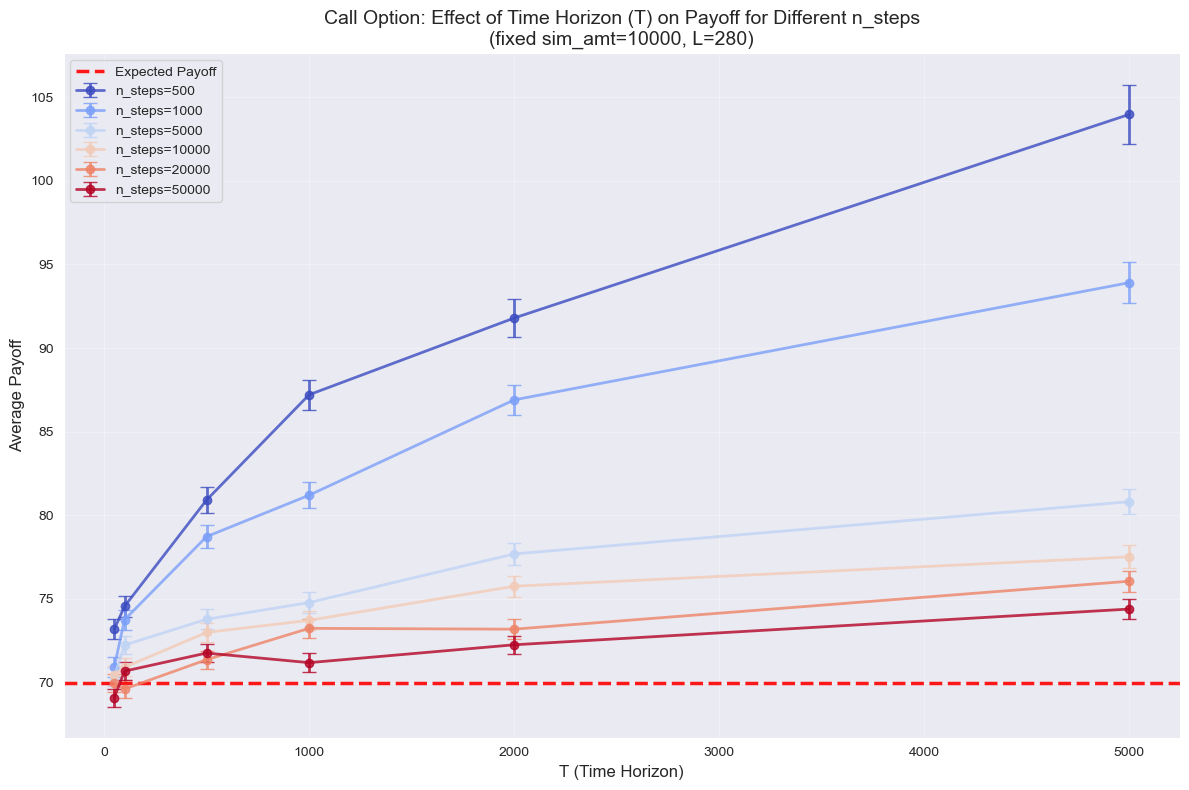

Benchmark boundary: L = 280
Intrinsic value if exercised immediately (S0 - K): 0.0000


In [72]:
# Plot: Effect of T on payoff while changing n_steps for Call Options
fig, ax = plt.subplots(figsize=(12, 8))

fixed_sim_amt_call = 10000

# Create a colormap that varies with n_steps
cmap = plt.cm.coolwarm
colors_call = [cmap(i / (len(n_steps_values_call) - 1)) for i in range(len(n_steps_values_call))]

theoretical_payoff = (benchmark_L_call-K) * (S0 / benchmark_L_call)  # For very high L, this approaches S0 - K

for idx, n_steps_val in enumerate(n_steps_values_call):
    subset = benchmark_df_call[(benchmark_df_call['simulation_amounts'] == fixed_sim_amt_call) & 
                          (benchmark_df_call['n_steps'] == n_steps_val)]
    if len(subset) > 0:  # Only plot if data exists
        ax.errorbar(subset['T'], subset['avg_payoff'], yerr=subset['std_payoff'], 
                    marker='o', label=f'n_steps={n_steps_val}', 
                    color=colors_call[idx], capsize=5, alpha=0.8, linewidth=2, markersize=6)

# Add a reference line at zero
ax.axhline(y=theoretical_payoff, color='red', linestyle='--', linewidth=2.5,
           label='Expected Payoff', alpha=0.9)

ax.set_xlabel('T (Time Horizon)', fontsize=12)
ax.set_ylabel('Average Payoff', fontsize=12)
ax.set_title(f'Call Option: Effect of Time Horizon (T) on Payoff for Different n_steps\n(fixed sim_amt={fixed_sim_amt_call}, L={benchmark_L_call:.0f})', 
             fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Benchmark boundary: L = {benchmark_L_call:.0f}")
print(f"Intrinsic value if exercised immediately (S0 - K): {max(S0 - K, 0):.4f}")

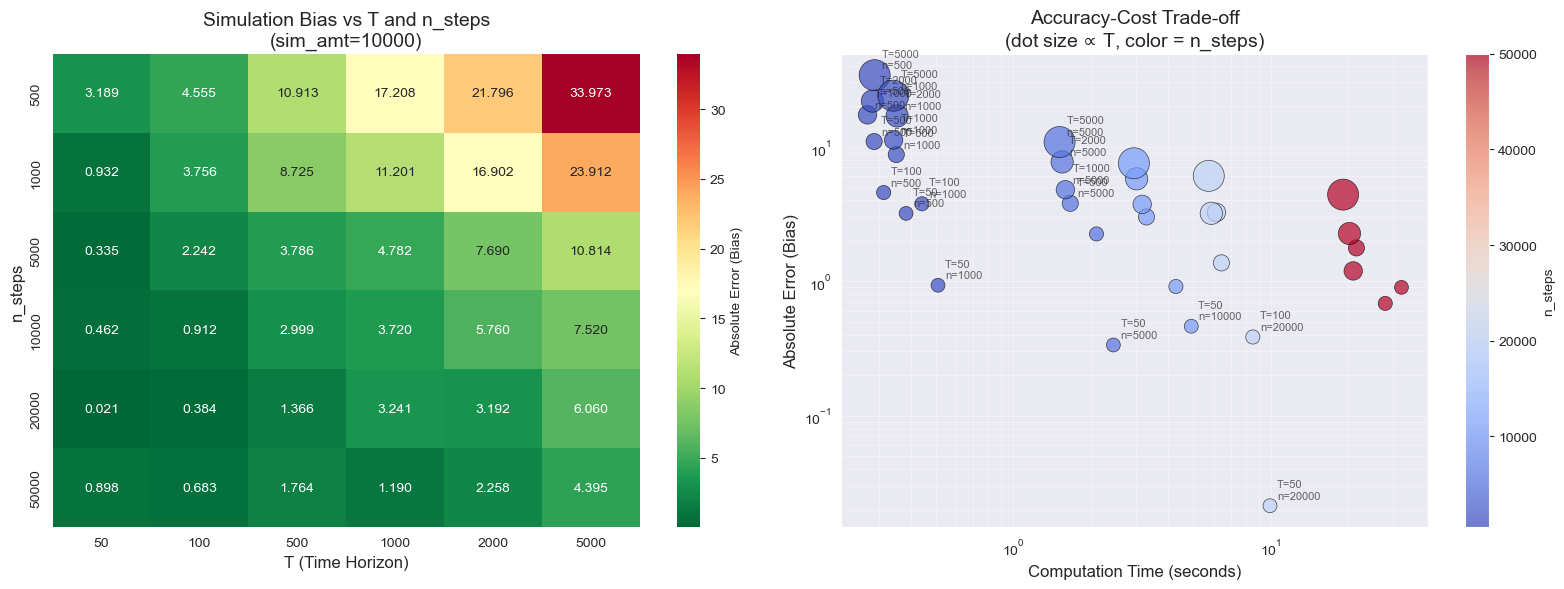


Accuracy-Cost Analysis:
Theoretical payoff: 70.0000

Best accuracy (lowest abs_error):
  T=50, n_steps=20000
  Error: 0.0214, Time: 9.95s

Best efficiency (lowest abs_error × time):
  T=5000, n_steps=1000
  Error: 33.7545, Time: 0.20s


In [73]:
# Plot: Error and time analysis - showing the accuracy-cost trade-off
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

fixed_sim_amt = 10000

# Calculate absolute error (bias) from theoretical value
benchmark_df_call['abs_error'] = np.abs(benchmark_df_call['avg_payoff'] - theoretical_payoff)

# 1. Heatmap of absolute error (bias)
ax = axes[0]
pivot_error = benchmark_df_call[benchmark_df_call['simulation_amounts'] == fixed_sim_amt].pivot(
    index='n_steps', columns='T', values='abs_error'
)
sns.heatmap(pivot_error, annot=True, fmt='.3f', cmap='RdYlGn_r', ax=ax, 
            cbar_kws={'label': 'Absolute Error (Bias)'})
ax.set_title(f'Simulation Bias vs T and n_steps\n(sim_amt={fixed_sim_amt})', fontsize=14)
ax.set_xlabel('T (Time Horizon)', fontsize=12)
ax.set_ylabel('n_steps', fontsize=12)

# 2. Efficiency scatter plot: error vs time, sized by T, colored by n_steps
ax = axes[1]
subset = benchmark_df_call[benchmark_df_call['simulation_amounts'] == fixed_sim_amt]

# Create size array based on T values (larger T = larger dots)
T_min, T_max = subset['T'].min(), subset['T'].max()
sizes = 100 + 400 * (subset['T'] - T_min) / (T_max - T_min)

scatter = ax.scatter(subset['time_seconds'], subset['abs_error'], 
                     c=subset['n_steps'], s=sizes, alpha=0.7, cmap='coolwarm',
                     edgecolors='black', linewidth=0.5)

# Add colorbar for n_steps
cbar = plt.colorbar(scatter, ax=ax, label='n_steps')

# Annotate a few key points
for idx, row in subset.iterrows():
    if row['abs_error'] < 0.5 or row['time_seconds'] < 2:  # Annotate interesting points
        ax.annotate(f"T={int(row['T'])}\nn={int(row['n_steps'])}", 
                   xy=(row['time_seconds'], row['abs_error']),
                   xytext=(5, 5), textcoords='offset points', 
                   fontsize=8, alpha=0.7)

ax.set_xlabel('Computation Time (seconds)', fontsize=12)
ax.set_ylabel('Absolute Error (Bias)', fontsize=12)
ax.set_title(f'Accuracy-Cost Trade-off\n(dot size $∝$ T, color = n_steps)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nAccuracy-Cost Analysis:")
print(f"Theoretical payoff: {theoretical_payoff:.4f}")
print(f"\nBest accuracy (lowest abs_error):")
best_acc = benchmark_df_call.loc[benchmark_df_call['abs_error'].idxmin()]
print(f"  T={int(best_acc['T'])}, n_steps={int(best_acc['n_steps'])}")
print(f"  Error: {best_acc['abs_error']:.4f}, Time: {best_acc['time_seconds']:.2f}s")
print(f"\nBest efficiency (lowest abs_error × time):")
benchmark_df['error_time_product'] = benchmark_df['abs_error'] * benchmark_df['time_seconds']
best_eff = benchmark_df.loc[benchmark_df['error_time_product'].idxmin()]
print(f"  T={int(best_eff['T'])}, n_steps={int(best_eff['n_steps'])}")
print(f"  Error: {best_eff['abs_error']:.4f}, Time: {best_eff['time_seconds']:.2f}s")

Compared to the put option case, the call option simulation requires more timesteps even for smaller time horizon in order to obtain accurate payoff that simulates the value of the perpetual option. 

# Conclusion

This notebook explored perpetual American options through analytical formulas and Monte Carlo simulation, providing insights into optimal exercise strategies and computational requirements.

**Perpetual American Put Options:**
- Validated the analytical solution for perpetual American puts with optimal exercise boundary $L_* = \frac{2r}{2r+\sigma^2}K$ using Monte Carlo simulations
- Benchmarking revealed that moderate simulation parameters (T ≈ 500, n_steps ≈ 500) provide sufficient accuracy with sub-second computation times
- The optimal strategy is to exercise the put when the stock price falls to the boundary $L_*$, balancing immediate exercise value against the option's time value

**Perpetual American Call Options:**
- For non-dividend-paying stocks, the optimal strategy is to **never exercise early** (infinite exercise boundary)
- This reflects the fact that holding the call option is always more valuable than exercising, as it retains both intrinsic value and time value
- Monte Carlo simulations confirmed theoretical value of option, which increases monotonically for increasing $L$
- Call option simulations require longer time horizons and more discretization steps than put options to accurately capture the "never exercise" behavior

# References:

Shreve, S. E. (2004). Stochastic calculus for finance II: Continuous-time models. Springer.

Privault, N. (2025, October 16). American options (Chapter 15 of Notes on stochastic finance) [PDF]. Nanyang Technological University. https://personal.ntu.edu.sg/nprivault/MA5182/american-options.pdf

#